In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix #, classification_report, precision_score, roc_curve
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier

**Loading and shuffling dataset**

In [2]:
df = pd.read_csv('dataset/dataset.csv')
df = shuffle(df, random_state = 42)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
4774,Typhoid,chills,vomiting,fatigue,high_fever,headache,nausea,constipation,abdominal_pain,diarrhoea,toxic_look_(typhos),belly_pain,NaN,NaN,NaN,NaN,NaN,NaN
3398,(vertigo) Paroymsal Positional Vertigo,vomiting,headache,nausea,spinning_movements,loss_of_balance,unsteadiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
889,AIDS,muscle_wasting,patches_in_throat,high_fever,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4198,Chicken pox,itching,skin_rash,fatigue,lethargy,high_fever,headache,loss_of_appetite,mild_fever,swelled_lymph_nodes,malaise,red_spots_over_body,NaN,NaN,NaN,NaN,NaN,NaN
3553,Pneumonia,chills,fatigue,cough,high_fever,breathlessness,sweating,malaise,phlegm,chest_pain,fast_heart_rate,rusty_sputum,NaN,NaN,NaN,NaN,NaN,NaN


# **Pre-Processing**

**Removing _ from strings**

In [3]:
for col in df.columns:
    df[col] = df[col].str.replace('_', ' ')
    df[col] = df[col].str.strip()
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
4774,Typhoid,chills,vomiting,fatigue,high fever,headache,nausea,constipation,abdominal pain,diarrhoea,toxic look (typhos),belly pain,NaN,NaN,NaN,NaN,NaN,NaN
3398,(vertigo) Paroymsal Positional Vertigo,vomiting,headache,nausea,spinning movements,loss of balance,unsteadiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
889,AIDS,muscle wasting,patches in throat,high fever,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4198,Chicken pox,itching,skin rash,fatigue,lethargy,high fever,headache,loss of appetite,mild fever,swelled lymph nodes,malaise,red spots over body,NaN,NaN,NaN,NaN,NaN,NaN
3553,Pneumonia,chills,fatigue,cough,high fever,breathlessness,sweating,malaise,phlegm,chest pain,fast heart rate,rusty sputum,NaN,NaN,NaN,NaN,NaN,NaN


**Dataset characteristics**

In [4]:
df.describe()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
count,4929,4929,4929,4929,4580,3714,2934,2268,1944,1692,1512,1194,744,504,306,240,192,72
unique,42,37,51,56,52,38,32,26,21,22,21,18,11,8,4,3,3,1
top,Typhoid,vomiting,vomiting,fatigue,high fever,headache,nausea,abdominal pain,abdominal pain,yellowing of eyes,yellowing of eyes,irritability,malaise,runny nose,chest pain,chest pain,loss of smell,muscle pain
freq,120,822,870,726,378,348,390,264,276,228,198,120,126,72,96,144,72,72


**Check for null and NaN values**

In [5]:
null_values = df.apply(lambda x: sum(x.isnull())).to_frame(name = 'count')
print(null_values)

            count
Disease         0
Symptom_1       0
Symptom_2       0
Symptom_3       0
Symptom_4     349
Symptom_5    1215
Symptom_6    1995
Symptom_7    2661
Symptom_8    2985
Symptom_9    3237
Symptom_10   3417
Symptom_11   3735
Symptom_12   4185
Symptom_13   4425
Symptom_14   4623
Symptom_15   4689
Symptom_16   4737
Symptom_17   4857


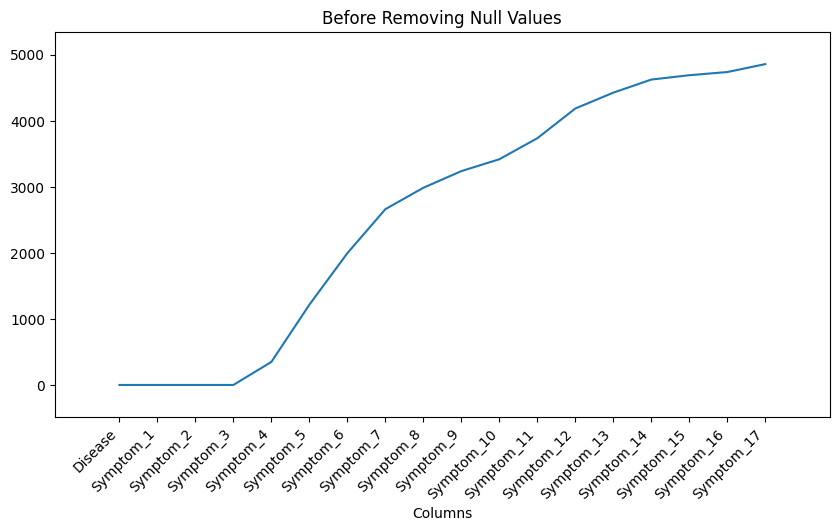

In [6]:
plt.figure(figsize = (10, 5))
plt.plot(null_values.index, null_values['count'])
plt.xticks(null_values.index, null_values.index, rotation = 45, horizontalalignment = 'right')
plt.title('Before Removing Null Values')
plt.xlabel('Columns')
plt.margins(0.1)
plt.show()

**Remove the trailing space from the symptom columns**

In [7]:
cols = df.columns
data = df[cols].values.flatten()

s = pd.Series(data)
s = s.str.strip()
s = s.values.reshape(df.shape)

df = pd.DataFrame(s, columns = df.columns)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Typhoid,chills,vomiting,fatigue,high fever,headache,nausea,constipation,abdominal pain,diarrhoea,toxic look (typhos),belly pain,NaN,NaN,NaN,NaN,NaN,NaN
1,(vertigo) Paroymsal Positional Vertigo,vomiting,headache,nausea,spinning movements,loss of balance,unsteadiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AIDS,muscle wasting,patches in throat,high fever,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Chicken pox,itching,skin rash,fatigue,lethargy,high fever,headache,loss of appetite,mild fever,swelled lymph nodes,malaise,red spots over body,NaN,NaN,NaN,NaN,NaN,NaN
4,Pneumonia,chills,fatigue,cough,high fever,breathlessness,sweating,malaise,phlegm,chest pain,fast heart rate,rusty sputum,NaN,NaN,NaN,NaN,NaN,NaN


**Fill the NaN values with zero**

In [8]:
df = df.fillna(0)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Typhoid,chills,vomiting,fatigue,high fever,headache,nausea,constipation,abdominal pain,diarrhoea,toxic look (typhos),belly pain,0,0,0,0,0,0
1,(vertigo) Paroymsal Positional Vertigo,vomiting,headache,nausea,spinning movements,loss of balance,unsteadiness,0,0,0,0,0,0,0,0,0,0,0
2,AIDS,muscle wasting,patches in throat,high fever,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Chicken pox,itching,skin rash,fatigue,lethargy,high fever,headache,loss of appetite,mild fever,swelled lymph nodes,malaise,red spots over body,0,0,0,0,0,0
4,Pneumonia,chills,fatigue,cough,high fever,breathlessness,sweating,malaise,phlegm,chest pain,fast heart rate,rusty sputum,0,0,0,0,0,0


In [9]:
df.tail()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
4924,Psoriasis,skin rash,joint pain,skin peeling,silver like dusting,small dents in nails,inflammatory nails,0,0,0,0,0,0,0,0,0,0,0
4925,Peptic ulcer diseae,vomiting,indigestion,loss of appetite,abdominal pain,internal itching,0,0,0,0,0,0,0,0,0,0,0,0
4926,Dengue,skin rash,chills,joint pain,vomiting,fatigue,high fever,headache,nausea,loss of appetite,pain behind the eyes,back pain,malaise,muscle pain,red spots over body,0,0,0
4927,Fungal infection,itching,skin rash,nodal skin eruptions,dischromic patches,0,0,0,0,0,0,0,0,0,0,0,0,0
4928,Drug Reaction,itching,skin rash,stomach pain,burning micturition,spotting urination,0,0,0,0,0,0,0,0,0,0,0,0


**Symptom severity rank**

In [10]:
df1 = pd.read_csv('dataset/symptom_weights.csv')
df1['Symptom'] = df1['Symptom'].str.replace('_', ' ')
df1

,Symptom,weight
0,itching,1
1,skin rash,3
2,nodal skin eruptions,4
3,continuous sneezing,4
4,shivering,5
...,...,...
130,red sore around nose,2
131,yellow crust ooze,3
132,prognosis,5
133,tiredness,5


**Get overall list of symptoms**

In [16]:
df1['Symptom'].unique()

array(['itching', 'skin rash', 'nodal skin eruptions',
       'continuous sneezing', 'shivering', 'chills', 'joint pain',
       'stomach pain', 'acidity', 'ulcers on tongue', 'muscle wasting',
       'vomiting', 'burning micturition', 'spotting urination', 'fatigue',
       'weight gain', 'anxiety', 'cold hands and feets', 'mood swings',
       'weight loss', 'restlessness', 'lethargy', 'patches in throat',
       'irregular sugar level', 'cough', 'high fever', 'sunken eyes',
       'breathlessness', 'sweating', 'dehydration', 'indigestion',
       'headache', 'yellowish skin', 'dark urine', 'nausea',
       'loss of appetite', 'pain behind the eyes', 'back pain',
       'constipation', 'abdominal pain', 'diarrhoea', 'mild fever',
       'yellow urine', 'yellowing of eyes', 'acute liver failure',
       'fluid overload', 'swelling of stomach', 'swelled lymph nodes',
       'malaise', 'blurred and distorted vision', 'phlegm',
       'throat irritation', 'redness of eyes', 'sinus pressu

**Encode symptoms in the data with the symptom rank**

In [19]:
vals = df.values
symptoms = df1['Symptom'].unique()

for i in range(len(symptoms)):
    vals[vals == symptoms[i]] = df1[df1['Symptom'] == symptoms[i]]['weight'].values[0]
    
d = pd.DataFrame(vals, columns = cols)
d.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Typhoid,3,5,4,7,3,5,4,4,6,5,4,0,0,0,0,0,0
1,(vertigo) Paroymsal Positional Vertigo,5,3,5,6,4,4,0,0,0,0,0,0,0,0,0,0,0
2,AIDS,3,6,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Chicken pox,1,3,4,2,7,3,4,5,6,6,3,0,0,0,0,0,0
4,Pneumonia,3,4,4,7,4,3,6,5,7,5,4,0,0,0,0,0,0


**Assign symptoms with no rank to zero**

In [20]:
d = d.replace('dischromic  patches', 0)
d = d.replace('spotting  urination', 0)
df = d.replace('foul smell of urine', 0)
df.head(10)

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Typhoid,3,5,4,7,3,5,4,4,6,5,4,0,0,0,0,0,0
1,(vertigo) Paroymsal Positional Vertigo,5,3,5,6,4,4,0,0,0,0,0,0,0,0,0,0,0
2,AIDS,3,6,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Chicken pox,1,3,4,2,7,3,4,5,6,6,3,0,0,0,0,0,0
4,Pneumonia,3,4,4,7,4,3,6,5,7,5,4,0,0,0,0,0,0
5,Hepatitis B,1,4,2,3,4,4,4,4,4,6,5,2,0,0,0,0,0
6,Hepatitis C,4,3,5,4,4,5,0,0,0,0,0,0,0,0,0,0,0
7,Peptic ulcer diseae,5,5,4,5,4,0,0,0,0,0,0,0,0,0,0,0,0
8,Impetigo,3,7,4,2,3,0,0,0,0,0,0,0,0,0,0,0,0
9,Diabetes,4,3,5,2,5,5,4,5,4,0,0,0,0,0,0,0,0


# **Exploratory Data Analysis**

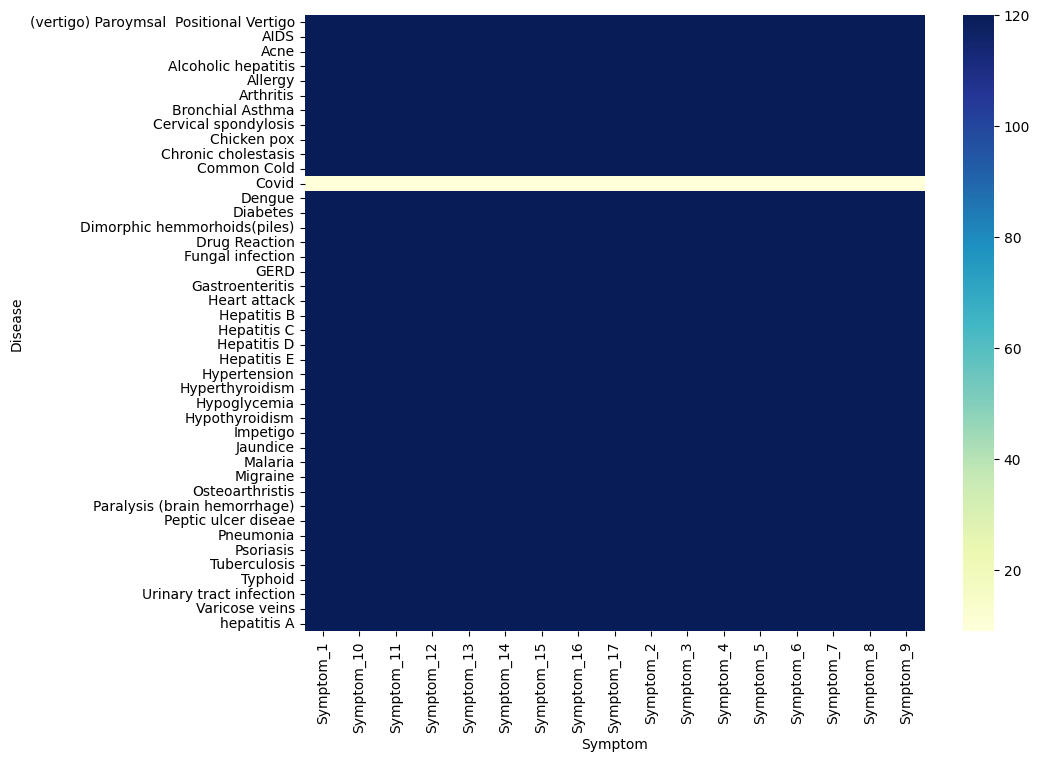

In [21]:
melted_df = pd.melt(df, id_vars = ['Disease'], var_name = 'Symptom')

pivot_df = melted_df.pivot_table(index = 'Disease', columns = 'Symptom', aggfunc = 'size', fill_value = 0)

plt.figure(figsize = (10, 8))
sns.heatmap(pivot_df, cmap = 'YlGnBu')
plt.show()

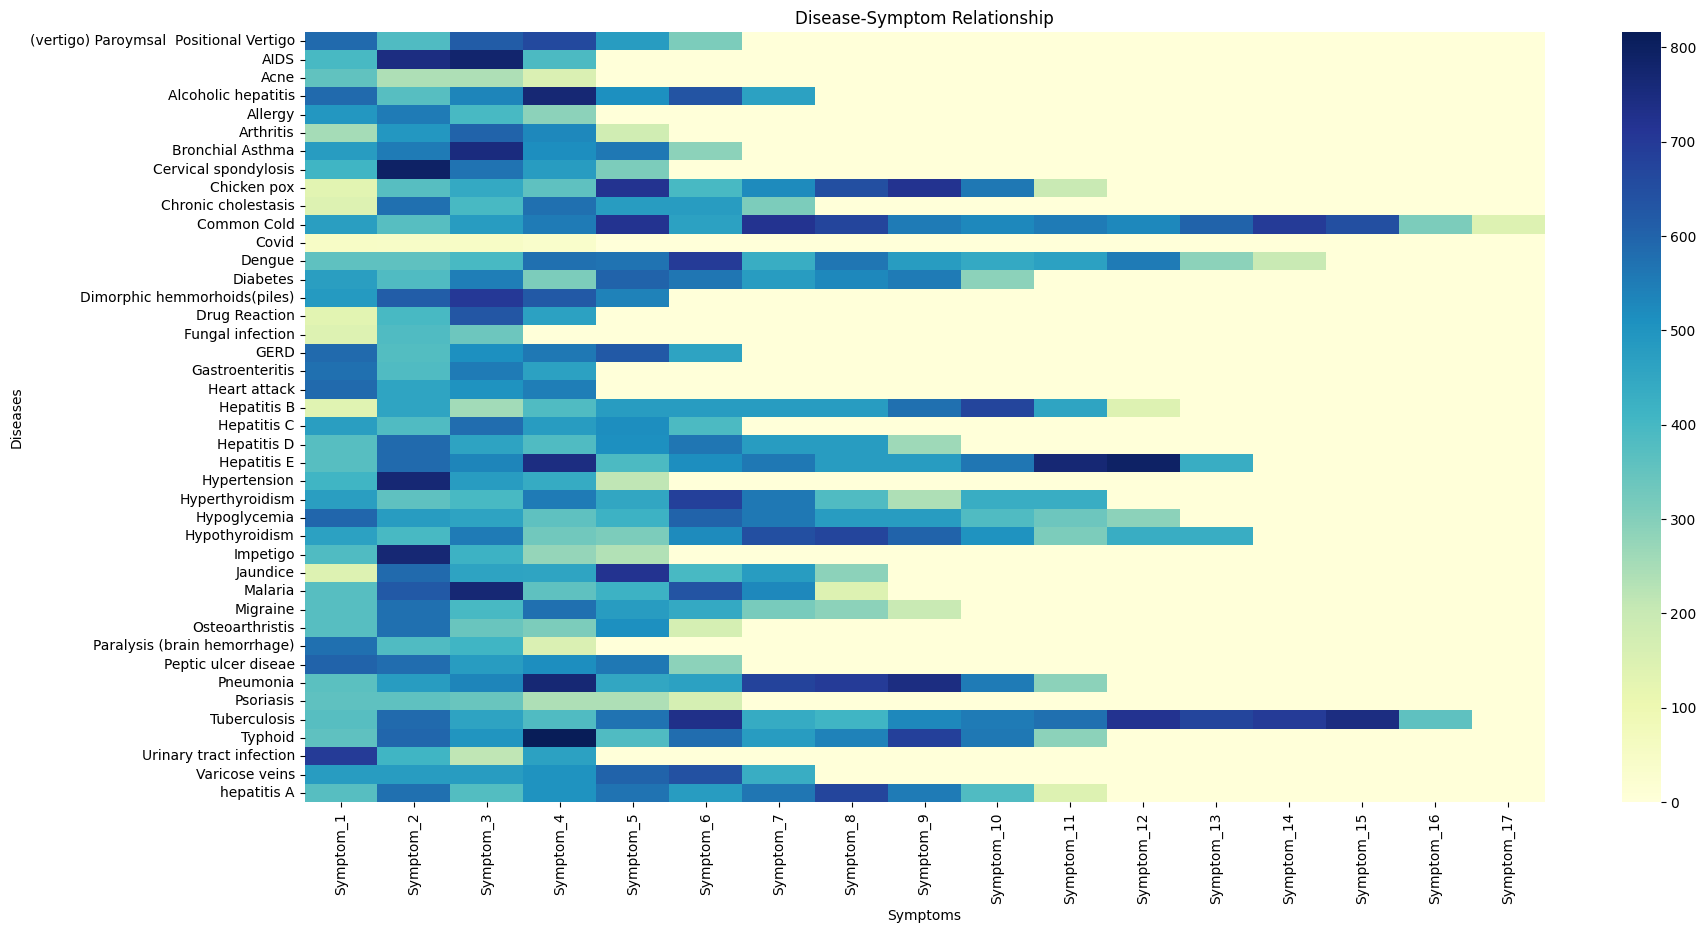

In [22]:
disease_symptom_df = df.groupby('Disease').sum()

plt.figure(figsize = (20, 10))
sns.heatmap(disease_symptom_df, cmap = 'YlGnBu')
plt.title('Disease-Symptom Relationship')
plt.xlabel('Symptoms')
plt.ylabel('Diseases')
plt.show()

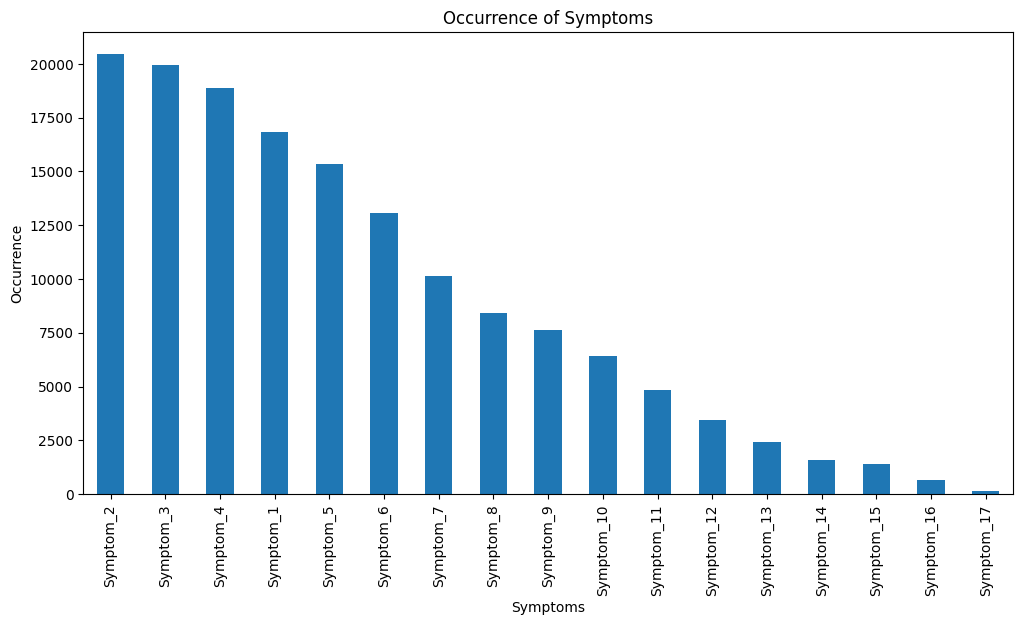

In [23]:
symptom_counts = df.iloc[:, 1:].sum()
symptom_counts.sort_values(ascending = False, inplace = True)

symptom_counts.plot(kind = 'bar', figsize = (12, 6))
plt.title('Occurrence of Symptoms')
plt.xlabel('Symptoms')
plt.ylabel('Occurrence')
plt.show()

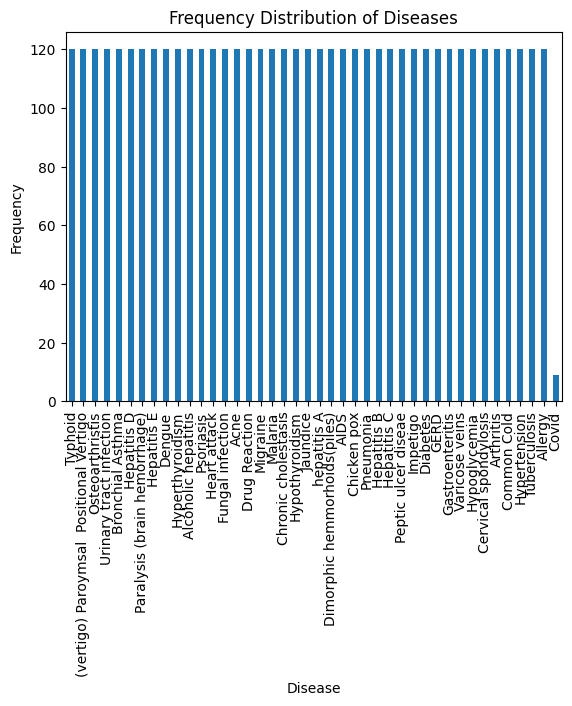

In [24]:
disease_counts = df['Disease'].value_counts()
disease_counts.plot(kind = 'bar')
plt.title('Frequency Distribution of Diseases')
plt.xlabel('Disease')
plt.ylabel('Frequency')
plt.show()

**Checking for Null Values Again**

In [25]:
null_values = df.apply(lambda x: sum(x.isnull())).to_frame(name = 'count')
print(null_values)

            count
Disease         0
Symptom_1       0
Symptom_2       0
Symptom_3       0
Symptom_4       0
Symptom_5       0
Symptom_6       0
Symptom_7       0
Symptom_8       0
Symptom_9       0
Symptom_10      0
Symptom_11      0
Symptom_12      0
Symptom_13      0
Symptom_14      0
Symptom_15      0
Symptom_16      0
Symptom_17      0


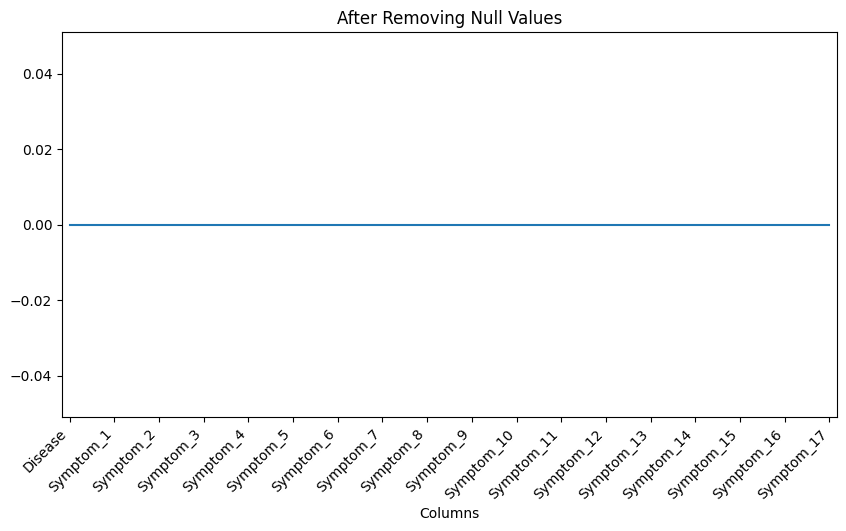

In [26]:
plt.figure(figsize = (10, 5))
plt.plot(null_values.index, null_values['count'])
plt.xticks(null_values.index, null_values.index, rotation = 45, horizontalalignment = 'right')
plt.title('After Removing Null Values')
plt.xlabel('Columns')
plt.margins(0.01)
plt.show()

# **Feature Selection**

In [27]:
print("Number of Symptoms used to Identify the Diseases: ", len(df1['Symptom'].unique()))
print("Number of Diseases that can be Identified: ", len(df['Disease'].unique()))

Number of Symptoms used to Identify the Diseases:  134
Number of Diseases that can be Identified:  42


**Get the names of diseases from data**

In [28]:
df['Disease'].unique()

array(['Typhoid', '(vertigo) Paroymsal  Positional Vertigo', 'AIDS',
       'Chicken pox', 'Pneumonia', 'Hepatitis B', 'Hepatitis C',
       'Peptic ulcer diseae', 'Impetigo', 'Diabetes', 'GERD',
       'Gastroenteritis', 'Varicose veins', 'Hypoglycemia',
       'Cervical spondylosis', 'Arthritis', 'Common Cold', 'Hypertension',
       'Tuberculosis', 'Dimorphic hemmorhoids(piles)', 'hepatitis A',
       'Jaundice', 'Hypothyroidism', 'Osteoarthristis',
       'Urinary tract infection', 'Bronchial Asthma', 'Hepatitis D',
       'Paralysis (brain hemorrhage)', 'Hepatitis E', 'Dengue',
       'Hyperthyroidism', 'Alcoholic hepatitis', 'Psoriasis',
       'Heart attack', 'Fungal infection', 'Acne', 'Drug Reaction',
       'Migraine', 'Malaria', 'Chronic cholestasis', 'Covid', 'Allergy'],
      dtype=object)

In [29]:
data = df.iloc[:,1:].values
labels = df['Disease'].values

## Splitting the dataset to training (80%) and testing (20%)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8, random_state = 42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3943, 17) (986, 17) (3943,) (986,)


# **Model Training & Evaluation**

# Decision Tree

F1-score% = 90.78600629865508 | Accuracy% = 93.10344827586206


<Axes: >

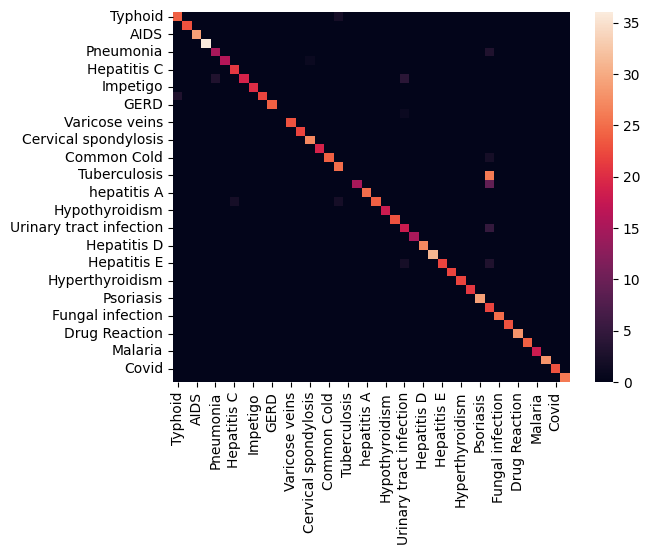

In [36]:
tree = DecisionTreeClassifier(criterion = 'gini', random_state = 42, max_depth = 13)
tree.fit(x_train, y_train)
preds = tree.predict(x_test)
conf_mat = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(conf_mat, index = df['Disease'].unique(), columns = df['Disease'].unique())
print('F1-score% =', f1_score(y_test, preds, average = 'macro') * 100, '|', 'Accuracy% =', accuracy_score(y_test, preds) * 100)
sns.heatmap(df_cm)

In [37]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 42)
DS_train = cross_val_score(tree, x_train, y_train, cv = kfold, scoring='accuracy')
pd.DataFrame(DS_train,columns = ['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (DS_train.mean() * 100.0, DS_train.std() * 100.0))

Mean Accuracy: 95.080%, Standard Deviation: (2.22%)


In [38]:
kfold = KFold(n_splits = 10,shuffle = True, random_state = 42)
DS_test = cross_val_score(tree, x_test, y_test, cv = kfold, scoring = 'accuracy')
pd.DataFrame(DS_test, columns = ['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (DS_test.mean() * 100.0, DS_test.std() * 100.0))

Mean Accuracy: 95.334%, Standard Deviation: (1.65%)


# Random Forest

F1-score% = 96.76226896897782 | Accuracy% = 99.08722109533468


<Axes: >

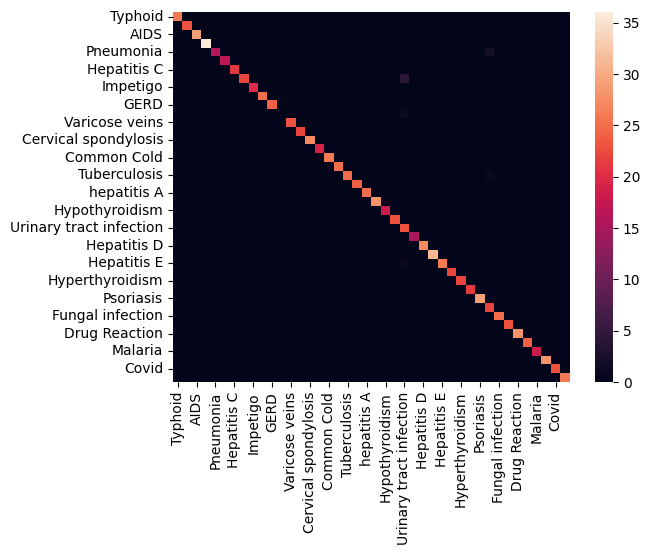

In [40]:
rnd_forest = RandomForestClassifier(random_state = 42, max_features = 'sqrt', n_estimators = 500, max_depth = 13)
rnd_forest.fit(x_train,y_train)
preds=rnd_forest.predict(x_test)
conf_mat = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(conf_mat, index = df['Disease'].unique(), columns = df['Disease'].unique())
print('F1-score% =', f1_score(y_test, preds, average = 'macro') * 100, '|', 'Accuracy% =', accuracy_score(y_test, preds) * 100)
sns.heatmap(df_cm)

In [41]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 42)
rnd_forest_train = cross_val_score(rnd_forest, x_train, y_train, cv = kfold, scoring = 'accuracy')
pd.DataFrame(rnd_forest_train, columns = ['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (rnd_forest_train.mean() * 100.0, rnd_forest_train.std() * 100.0))

Mean Accuracy: 99.290%, Standard Deviation: (0.42%)


In [42]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 42)
rnd_forest_test = cross_val_score(rnd_forest, x_test, y_test, cv = kfold, scoring = 'accuracy')
pd.DataFrame(rnd_forest_test, columns=['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (rnd_forest_test.mean() * 100.0, rnd_forest_test.std() * 100.0))

Mean Accuracy: 98.683%, Standard Deviation: (1.01%)


**Save Random Forest model**

In [48]:
saved_rf = pickle.dumps(rnd_forest)

with open('random_forest.pkl', 'wb') as file:
    file.write(saved_rf)

## Comparison Between Both Models

In [43]:
n_groups = 2
algorithms = ('Decision Tree', 'Random Forest')
train_accuracy = (DS_train.mean() * 100.0,
                 rnd_forest_train.mean() * 100.0,)

In [44]:
test_accuracy = (DS_test.mean() * 100.0,
                 rnd_forest_test.mean() * 100.0)

In [45]:
Standard_Deviation=(DS_test.std() * 100.0,     
                 rnd_forest_test.std() * 100.0)

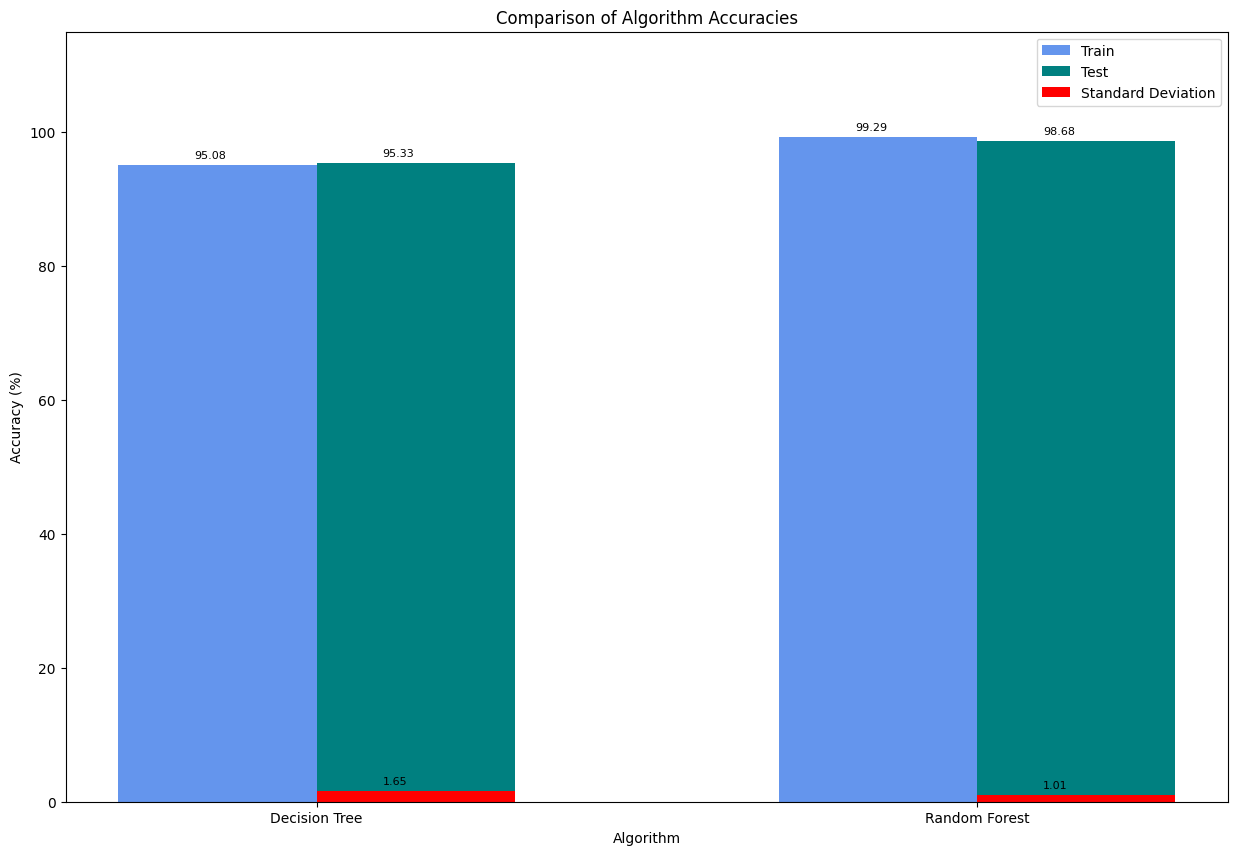

In [46]:
fig, ax = plt.subplots(figsize = (15, 10))
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1
rects1 = plt.bar(index, train_accuracy, bar_width, alpha = opacity, color = 'Cornflowerblue', label = 'Train')
rects2 = plt.bar(index + bar_width, test_accuracy, bar_width, alpha = opacity, color = 'Teal', label = 'Test')
rects3 = plt.bar(index + bar_width, Standard_Deviation, bar_width, alpha = opacity, color = 'red', label = 'Standard Deviation')
plt.xlabel('Algorithm') # X-axis label
plt.ylabel('Accuracy (%)') # Y-axis label
plt.ylim(0, 115)
plt.title('Comparison of Algorithm Accuracies') # plot Title
plt.xticks(index + bar_width * 0.5, algorithms) # X-axis Data Labels
plt.legend(loc = 'upper right') # Legend
for index, data in enumerate(train_accuracy):
    plt.text(x = index - 0.035, y = data + 1, s = round(data, 2), fontdict = dict(fontsize = 8))
for index, data in enumerate(test_accuracy):
    plt.text(x = index + 0.25, y = data + 1, s = round(data, 2), fontdict = dict(fontsize = 8))
for index, data in enumerate(Standard_Deviation):
    plt.text(x = index + 0.25, y = data + 1, s = round(data, 2), fontdict = dict(fontsize = 8))    